In [1]:
#!pip install python-Levenshtein
#!pip install textblob 
#!pip install pyspellchecker
#!pip install gTTS
#!pip install pygame

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import io, os, re
import numpy as np
import pandas as pd
import sklearn
import string
import time, warnings
from sklearn.model_selection import train_test_split
from random import randrange
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from textblob import Word 
import random, sys
from difflib import SequenceMatcher
from spellchecker import SpellChecker
from collections import Counter

from pygame import mixer  # Load the popular external library
from gtts import gTTS # Import the required module for text-to-speech conversion

# CONGFIGURABILITY OPTIONS
text_to_speech = True # Whether the chatbot speaks or not 
use_lev = True # Use the Levenshtein edit or not. It is also a configurability rule of the dialog system.
allow_restart = True # Allow the system to restart if an entered utterance is classified as 'restart'.
change_pref = True # Allow the user to change preferences after their first choice. If we dont allow it, we should definitely allow the system to restart, because in such cases we restart the chat. 

pygame 2.6.1 (SDL 2.28.4, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [18]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return(result_str)

def create_mp3_file(mytext):   
    # Language in which you want to convert
    language = 'en'

    # Passing the text and language to the engine,
    # here we have marked slow=False. Which tells
    # the module that the converted audio should
    # have a high speed
    myobj = gTTS(text=mytext, lang=language, slow=False)
    
    if(text_to_speech):
        # Saving the converted audio in a mp3 file named welcome
        path = "C:/Users/yugio/Projects/MAIR/Chatbot/" 
        random_string = get_random_string(5)
        file = random_string + ".mp3"
        final_path = path + file 
        myobj.save(final_path)
        mixer.init()
        mixer.music.load(final_path)
        mixer.music.play()
    

## Part 1 - Data, Algorithms, Machine Learning

In [34]:
class Files():

    def __init__(self, file_name) -> None:
        self.df = pd.read_csv(file_name)
        self.dialog_data = np.array(self.df)
                
    def separete_labels_utt(self,my_list):
        self.my_list = my_list
        for i in self.dialog_data:
            for j in i[0]:
                if(j == ' '):
                    label_utt = i[0].split(' ', 1)
                    self.my_list.append(label_utt)
                    break

    def make_a_dataframe(self):
        self.dialog_data = np.array(self.my_list)
        self.dialog_frame = pd.DataFrame(self.dialog_data, columns=['Label', 'Utterance'])
        for i in range(len(self.dialog_frame)):
            self.dialog_frame.loc[i, "Utterance"] = self.dialog_frame.loc[i, "Utterance"].replace(";", "")
        return(self.dialog_frame,self.dialog_data)

    def keywords_lists(self):
        inform_list = ['thai', 'french', 'gastropub', 'matter']
        confirm_list = ['correct', 'does it']
        affirm_list = ['yes', 'right']
        request_list = ['what', 'how', 'which', 'type', 'phone', 'address', 'post', 'postcode']
        thankyou_list = ['thank']
        null_list = ['noise', 'uhm', 'eh', 'sil','unintelligible']
        bye_list = ['goodbye', 'bye']
        reqalts_list = ['what about', 'how about', 'anything', 'else', 'another', 'other']
        negate_list = ['no', 'nah']
        hello_list = ['hi', 'hey', 'hello']
        repeat_list = ['repeat', 'again']
        ack_list = ['okay', 'kay', 'fine', 'good']
        restart_list = ['start', 'restart']
        deny_list = ['wrong', "don't", 'not']
        reqmore_list = ['more'] 
        #all the keys that were used for each label put in one dictionary
        self.all_keys_list = [inform_list,reqalts_list,affirm_list,request_list,thankyou_list,null_list,bye_list,confirm_list,negate_list,hello_list,repeat_list,ack_list,restart_list,deny_list,reqmore_list]

    def create_dicitionaries(self):
        list_lab = list(self.dialog_frame.Label.unique())
        a, b = list_lab.index('confirm'), list_lab.index('reqalts') 
        list_lab[b], list_lab[a] = list_lab[a], list_lab[b]
        numbers = [i+1 for i in range(15)]
        self.my_dictionary = dict(zip(list_lab, numbers)) 
        self.inv_dictionary = {v: k for k, v in self.my_dictionary.items()} 
        self.labels_keys_dict = dict(zip(list_lab, self.all_keys_list)) 
        return(self.my_dictionary, self.inv_dictionary, self.labels_keys_dict)

    def to_numerical(self,a_list):
        numerical = []
        for i in range(len(a_list)):
            numerical.append(self.my_dictionary[a_list[i]])
        return(numerical)

    def nonsimilarity (self,actual, fake):
        pos_counter = np.zeros(15)
        for i in range(len(actual)):
            if (actual[i]!=fake[i]):
                pos_counter[actual[i]-1] = pos_counter[actual[i]-1] + 1
        max_values = np.where(pos_counter == np.amax(pos_counter))
        if (len(max_values[0])>1):
            print("Multiple values: ",max_values[0])
        return(self.inv_dictionary[max_values[0][0]+1])

    def return_as_dataframe(self):
        return(self.df)

In [35]:
class Algorithms():

    def __init__(self, algorithm_name, file_obj) -> None:
        self.al_name = algorithm_name
        self.file_obj = file_obj

    def zero_rule_algorithm_classification(self,all_data):
        print("Now you can test the zero rule algorithm by entering utterances (press 'exit' to exit)")
        output_values = [row[0] for row in all_data] 
        prediction = max(set(output_values), key=output_values.count) # calculate the max occuring label in the dataset
        x = input()
        while(x.lower()!='exit'):
            print("The most common label of the utterance entered is:", prediction)
            x = input()
        d_frame = self.file_obj.make_a_dataframe()[0]
        n_inform = d_frame[d_frame.Label == 'inform'] 
        print("The total number of correct classifications by the zero rule are:", n_inform.shape[0])
        print("The percentage accuracy of zero rule is %0.2f" % (n_inform.shape[0]/len(all_data)*100))
        return (n_inform.shape[0]/len(all_data)*100)
          
    def random_algorithm(self,all_data, flag):
        output_values = [row[0] for row in all_data] 
        unique = list(set(output_values)) #unique is a list with the 15 given labels of dialog acts 
        index = randrange(len(unique))
        prediction = unique[index]
        return prediction

    def keyword_rule_algorithm_classification(self,labels_keys_dict,all_data):
        print("Now you can test the keyword rule algorithm by entering utterances (press 'exit' to exit)")
        x = input()
        while(x.lower()!='exit'):
            flag = True 
            for i in labels_keys_dict.items(): 
                for j in i[1]: 
                    temp = x.lower().split(' ')
                    if(len(j.split())<2):
                        if(j.lower() in temp):
                            print("The most common label of the utterance entered is:", i[0])
                            flag = False
                            break
                    else:   
                        if(j.lower() in x.lower()):
                            print("This is a phrase keyword")
                            print("The most common label of the utterance entered is:", i[0])
                            flag = False
                            break
                if(flag==False):
                    break  
            if(flag==True): 
                print("random guess")
                prd = self.random_algorithm(all_data,True)
                print("The most common label of the utterance entered is:", prd)
            x = input()
        
    def keyword_rule_algorithm_classification_train(self,utterance,labels_keys_dict):
        flag = True
        for i in labels_keys_dict.items():
            for j in i[1]:
                temp = utterance.lower().split()
                if(len(j.split())<2):
                    if(j.lower() in temp):
                        flag = False
                        return i[0]
                else:
                    if(j.lower() in utterance.lower()):
                        flag = False
                        return i[0]
            if(flag==False):
                break   
        if(flag==True): 
            prd = 'inform'
            return prd

    def keyword_rule_algorithm_results(self,dialog_frame,labels_keys_dict):
        result_list = [] 
        for i in range(len(dialog_frame)): 
            result_list.append(self.keyword_rule_algorithm_classification_train(dialog_frame["Utterance"][i],labels_keys_dict)) 

        correct = 0
        label_column = list(dialog_frame['Label']) 
        for i in range(len(result_list)):
            if (label_column[i]==result_list[i]):
                correct += 1

        print("The total number of correct classifications by the keyword rule are:", correct)
        print("The percentage accuracy of keyword rule is %0.2f" % (correct/len(label_column)*100))
        numerical_column = self.file_obj.to_numerical(label_column)
        numerical_result = self.file_obj.to_numerical(result_list) 
        most_errors = self.file_obj.nonsimilarity(np.asarray(numerical_column), np.asarray(numerical_result))
        print("The label in which most errors are observed is: ", most_errors)
        return(correct/len(label_column)*100)
      
    def get_algorithm(self,data,dictionary):
        if (self.al_name == 'zero_rule_algorithm_classification'):
            n_info = self.zero_rule_algorithm_classification(data)
            return(n_info)
        elif(self.al_name == 'keyword_rule_algorithm_classification'):
            self.keyword_rule_algorithm_classification(dictionary,data)
            n_labels = self.keyword_rule_algorithm_results(self.file_obj.make_a_dataframe()[0],dictionary)
            return(n_labels)

    def Statistics(self,dialog_frame):  
        column0, column1 = dialog_frame["Label"], dialog_frame["Utterance"]
        len_list = []  
        for i in range(len(dialog_frame)):  
            len_list.append(len(column1[i].split()))

        unique = list(set(column0))
        all_indicies = [] 
        for t in unique:
            indices = [i for i, x in enumerate(list(column0)) if x == t]
            all_indicies.append(len(indices))

        d1 = np.arange(len(unique))
        fig = plt.figure(figsize=(16,6))
        ax = fig.add_axes([0,0,1,1])
        plt.title("Label distribution among the 15 classes", fontsize=18)
        plt.xlabel('Classes-Lables', fontsize=18)
        plt.ylabel('Number of instances', fontsize=18)
        plt.bar(d1,all_indicies, color='b',width=0.5)
        plt.xticks([r for r in range(len(unique))], unique,rotation=0)
        plt.grid(True)
        plt.show()
        print("The maximum utterance length in the dataset is: ", max(len_list))
        print("The minimum utterance length in the dataset is: ", min(len_list))
        print("The average utterance length in the dataset is:  %0.3f"  %np.mean(len_list))  


In [36]:
class Machine_learning():

    def __init__(self, all_data, file_obj) -> None:
        self.y = all_data[:,0] 
        self.X = all_data[:,1] 
        self.count_vect = CountVectorizer()
        self.le = preprocessing.LabelEncoder()
        self.file_obj = file_obj

    def pre_processing (self):
        X_count = (self.count_vect).fit_transform(self.X) 
        print("X_encoded shape: ",X_count.shape)
        y_count = (self.le).fit_transform(self.y)
        print("y_encoded shape: ",y_count.shape)
        self.X_train_count, self.X_test_count, self.y_train_count, self.y_test_count = train_test_split(X_count, y_count, test_size=0.15, random_state=42) 
        print("X_train shape:", self.X_train_count.shape ,'|', "X_test shape:",self.X_test_count.shape, '|', "y_train shape:", self.y_train_count.shape, '|', "y_test shape:", self.y_test_count.shape)

    def ml_model_train_test(self,clf,mlname):
        warnings.simplefilter('ignore')
        clf.fit(self.X_train_count.astype(int), self.y_train_count.astype(int))
        scores = cross_val_score(clf, self.X_train_count.astype(int), self.y_train_count.astype(int), cv=5)
        print("The", mlname, "model on train set had %0.3f accuracy with a standard deviation of %0.2f" % (100*scores.mean(), 100*scores.std()))
        test_score = clf.score(self.X_test_count.astype(int), self.y_test_count.astype(int)) 
        results = clf.predict(self.X_test_count.astype(int))
        most_errors = self.file_obj.nonsimilarity(self.y_test_count.astype(int),results) 
        print("Accuracy on Test set for the", mlname, "model is: %0.3f"  %(100*test_score))
        print("The label on which the most errors are observed is: ", most_errors)
        warnings.filterwarnings('module') # or 'once', or 'always'
        return(100*test_score)

    def manual_input(self,clf,utterances_manual,inverse_dict):
        X_new_counts = (self.count_vect).transform(utterances_manual) 
        predicted = clf.predict(X_new_counts)
        for utt, category in zip(utterances_manual, predicted):
            print('%r => %s' % (utt, inverse_dict[category]))

    def pipeline_system(self,in_classifier,in_name):
        warnings.simplefilter('ignore')
        text_clf = Pipeline([('vect', self.count_vect),('clf', in_classifier)])
        text_clf.fit(self.X[0:int(0.85*len(self.X))], self.y[0:int(0.85*len(self.y))])
        predicted = text_clf.predict(self.X[int(0.85*len(self.X)):])
        warnings.filterwarnings('module')
        print("The accuracy of the", in_name, "pipeline system in test set is: %0.3f" %(100*np.mean(predicted == self.y[int(0.85*len(self.y)):])))
    
    def predict(self,inp, clf, inverse_dict): # a function that is used to predict manual inputs for machine learning models
        # inp: The incoming utterance, clf: One 1 of the 4 classifiers constructed to be used 
        X_new = self.count_vect.transform([inp])
        predicted = clf.predict(X_new)
        print(inverse_dict[predicted[0]])
        return(inverse_dict[predicted[0]]) 


class Machine_learning_model(Machine_learning):
    
    def decision_tree(self):
        self.classifier = DecisionTreeClassifier(random_state=0)
        return(self.classifier)

    def logistic_regression(self):
        self.classifier = LogisticRegression(random_state=0, max_iter=250)
        return(self.classifier)

    def support_vector_machine(self):
        self.classifier = svm.SVC(kernel='linear', C=1, random_state=42)
        return(self.classifier)

    def multi_layer_perceptron(self):
        self.classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(7, ), max_iter=400, learning_rate_init=0.002, random_state=1)
        return(self.classifier)
    

In [37]:
def plot_results(all_results):
    models = ['Zero Rule','Keyword Rule','Decision Trees','LogisticRegression','SVM','MLP']
    d1 = np.arange(len(models))
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_axes([0,0,1,1])
    plt.title("Algorithms Evaluation on Absolute Accuracy on Test set", fontsize=18)
    plt.xlabel('Algorithms', fontsize=18)
    plt.ylabel('Percentage (%)', fontsize=18)
    plt.ylim(0,110)
    plt.bar(d1,all_results, color='b',width=0.5)
    plt.xticks([r for r in range(len(models))], models,rotation=0)
    plt.yticks(np.arange(0,110,10))
    plt.grid(True)
    plt.show()

# PART 2 - Dialog Implementation, Chatbot

In [38]:
class Helper():

    def __init__(self,turns,starting_time,name) -> None:
        #self.File2 = Files('restaurant_info.csv')
        self.File3 = Files(name)
        #self.df2 = self.File2.return_as_dataframe()
        self.df3 = self.File3.return_as_dataframe()
        self.turns = turns
        self.t_start = starting_time
        self.area_list = ['west', 'east', 'south', 'north', 'centre', 'center']
        self.price_list = ['cheap', 'expensive', 'moderate']
        self.type_food_list = list(set(self.df3["food"]))
        self.dont_mind_list = ['any', 'dont', 'anywhere', 'doesnt', 'mind', 'matter', 'care', 'anything', 'whatever']
        self.extra_information_list = ['phone', 'number', 'address', 'post', 'code', 'postcode', 'all', 'three']
        self.reasoning_list = ['romantic', 'children', 'child', 'touristic', 'assigned' ,'seats', 'assigned seats']
        self.negate_list = ['wouldnt', 'dont', 'couldnt', 'not']
        self.vrisies_list = ['fuck', 'fucks', 'bastard', 'bitch', 'moron', 'fucking', 'idiot', 'stupid', 'blowjob', 'pussy', 'cock', 'asshole', 'fucker']
        self.vrisies = 0
        
    def clear_mp3_files(self, path):
        for file in os.listdir(path):
            if(file[-4:]=='.mp3'):
                try:
                    os.remove(path+file)
                except IOError:
                    print("------->", file)
                    print("The above file cannot be deleted because it is already opened on another app.")
    
    def Exit(self,inp):
        if(inp.lower()=='exit'):  
            print("SYSTEM: Thanks for using the chatbot. Goodbye!")     
            sys.exit()

    def Series_of_actions(self,lev):
        # lev: whether to use the levenshtein edit or not (configurability rule)
        self.turns += 1
        response = input('USER: ')
        response = response.lower()
        self.Exit(response) # It checks if the user entered 'exit' in order to terminate the chat immediately
        response = response.translate(str.maketrans('', '', string.punctuation)) # It remooves all punctuation marks
        if(lev==True):
            response = self.levenshtein_check(response) # It checks if any word of the entered phrase is misspelled
        if('center' in response.split()): # If the user types 'center' its actually a correct value for area, but the CSV corresponding value is 'centre' so we change it 
            response = response.replace('center','centre') 
        splitted_utterance = response.split()
        vrisia = set(splitted_utterance).intersection(self.vrisies_list)
        if(len(vrisia)>0):
            self.vrisies += 1
            if self.vrisies >= 2: 
                print("SYSTEM: Okay... I will terminate the conversation now")
                create_mp3_file("Okay... I will terminate the conversation now")
                time.sleep(4)
                sys.exit()
            print("SYSTEM: Sorry, but I don't think that you are speaking properly. If you say something like this again, I will terminate the conversation")
            #create_mp3_file("Go to hell mother fucker, I will shut down the conversation...")
            create_mp3_file("Sorry, but I don't think that you are speaking properly. If you say something like this again, I will terminate the conversation")
            time.sleep(10)
        return(response)

    def levenshtein_check(self,inp):
        # inp: the incoming utterance 
        inp_splitted = inp.split()
        hlist = [] 
        for i in inp_splitted:
            if(i=='touristic'): 
                hlist.append(i)
                continue
            hlist.append(SpellChecker().correction(i)) 
        return(' '.join(hlist)) # join the list to make it a utterance once again

    def Restart(self,inp,classed,dictionary):
        if(classed=='restart'): # Restart the program only if we classify the utterance as restart.
            chat = Chatbot('none','none','none', 0, dictionary, "C:/Users/yugio/Projects/MAIR/Chatbot/")
            if(allow_restart==True):
                chat.Main()
                sys.exit()

    def similar(self, a, splitted_phrase): # This function finds the most similar string to 'a' in the list 'splitted_phrase' and changes that string with 'a'
        # a: a random string
        # splitted_phrase: a list which has as elements the strings of a splitted phrase
        similarity_indices = []
        for b in splitted_phrase:
            similarity_indices.append(SequenceMatcher(None, a, b).ratio())
        ind = similarity_indices.index(max(similarity_indices))
        if([*splitted_phrase[ind]][0]!=[*a][0]): # this means we have something like 'inexpensive'
            splitted_phrase[ind] = a
            most_similar = random.choice([j for j in self.price_list if j!=a])
        else:
            most_similar = a
            splitted_phrase[ind] = a
        return (splitted_phrase,most_similar)

    def check_distance(self,split,negate,element,thresshold):
      # split: a splitted utterance in its words-components 
      # negate: a negate word like the 'not'
      # element: another word 
      # thresshold: how much in terms of word a negation will be from a target word. We use this func to extract denials in sentences.
        if((abs(split.index(element) - split.index(negate)))<=thresshold):
            return(True)
        else: 
            return(False)
  
    def check_existance(self,inp,checking_list): # a function that checks if a word co-exists in an utterance input and a random (global) list
      #inp: incoming utteracnce
      #checking list: the list from which we check if any element is in the incoming utterance
        for i in checking_list:
            if (i in inp):
                return(True)
        return(False)

    def negation_check(self,inp,rlist,element,choices_list):
        # inp: incoming utterance
        # rlist: a list that will be probably one of area, price or type food lists
        # element: a value that has been pointed that as 'concern' because a negation may refers to it
        # choices_list: a list that eventually will contain all the right values (or value) that needs to be retuned for the preference extraction
        splitted_utterance, most_smlr = inp.split(), element
        match = set(splitted_utterance).intersection(self.negate_list)
        if(len(match)>0):
            negation = match.pop()
            splitted_utterance,most_smlr = self.similar(element,splitted_utterance)
            if(splitted_utterance.index(element)>splitted_utterance.index(negation)): 
                thress = 6 if self.negate_list.index(negation) != self.negate_list.index(self.negate_list[-1]) else 4
                if(self.check_distance(splitted_utterance,negation,element,thress)): 
                    choices_list = [j for j in rlist if j!=element] 
                else:
                    choices_list.append(element)
            else:
                choices_list.append(element)
        else:
            _,most_smlr = self.similar(element,splitted_utterance)
            if (most_smlr==element):
                choices_list.append(element)
            else: choices_list.append(most_smlr)
        if('center' in choices_list):
            choices_list = list(map(lambda x: x.replace('center', 'centre'), choices_list))
            if(Counter(choices_list)['centre'] == 1): # from collections
                choices_list.remove('centre')
        return(choices_list)

    def mapping_price(self,inp,price,dictionary):
        temp1 = re.findall(r'\d+', inp) # find number of digits through regular expression
        res2 = list(map(int, temp1))
        if(len(res2)>0):
            Max = max(res2)
            if('per' not in inp):
                print("SYSTEM: Do you mean per person?")
                create_mp3_file("Do you mean per person?")
                response = self.Series_of_actions(use_lev)
                response,classified = self.null_func(response.lower(),dictionary)
                if(classified!='affirm'):
                    if(Max<=50):
                        price = 'cheap'
                    elif(Max>=50 and Max<150):
                        price = 'moderate'
                    else:
                        price = 'expensive'
                    return(price)
                else:
                    if(Max<=20):
                        price = 'cheap'
                    elif(Max>=20 and Max<50):
                        price = 'moderate'
                    else:
                        price = 'expensive'
                    return(price)
            else:
                if(Max<=20):
                    price = 'cheap'
                elif(Max>=20 and Max<50):
                    price = 'moderate'
                else:
                    price = 'expensive'
                return(price)        
        else:
            return(price)

    def null_func(self,inp,dictionary):
        # inp: The incoming utterance
        # dictionary: The dictionary with the keywords 
        name = 'keyword_rule_algorithm_classification'
        algo = Algorithms(name,self.File3)
        cls = algo.keyword_rule_algorithm_classification_train(inp,dictionary) # Call the keyword rule to classify the incoming utterance
        print("Classified as: ", cls)
        self.Restart(inp,cls,dictionary)
        if(cls=='bye'):
            print('SYSTEM: Thanks for using the chatbot. Goodbye!') 
            create_mp3_file("Thanks for using the chatbot. Goodbye!")
            print()
            t_finish = time.time()
            print('Total Runtime: %.2f s' %(t_finish-self.t_start))
            print('The total number of turns that needed were: ', self.turns)
            sys.exit()
        if(len(inp)<2):  #if the input is just 1 letter it is probably a user's mistake and will be classified as 'null'
            cls = 'null'
        while(cls=='null'): # a while loop that checks if the input is still 'null'
            print("SYSTEM: Sorry, I can't understand you. Can you repeat it please?")
            create_mp3_file("Sorry, I can't understand you. Can you repeat it please?")
            response = self.Series_of_actions(use_lev)
            cls = algo.keyword_rule_algorithm_classification_train(response,dictionary)
            print("Classified as: ", cls) 
            self.Restart(inp,cls,dictionary)
            if (cls=='hello'): # gives info when the input is classified as hello
                return(response,cls)
            if(cls=='bye'): # again exits when is classified as 'bye'
                print('SYSTEM: Thanks for using the chatbot. Goodbye!')
                create_mp3_file("Thanks for using the chatbot. Goodbye!")
                print()
                t_finish = time.time()
                print('Total Runtime: %.2f s' %(t_finish-self.t_start))
                print('The total number of turns that needed were: ', self.turns)
                sys.exit()
            if(len(response)<2): #  classifies it as 'null' when only 1 letter is given
                cls = 'null'
            inp = response
        return(inp,cls)

In [39]:
class Chatbot():

    def __init__(self,area,price,food,state,dictionary,path) -> None:
        self.area = area
        self.price = price
        self.type_of_food = food
        self.state = state 
        self.dictionary = dictionary
        self.my_helper_obj = Helper(0,time.time(),'restaurant_info_upgrade.csv')
        self.path = path

    def Reasoning_rule(self, cand_rest, wanted):
        # cand_rest: a datafame with the candidate restuarants up to the point where the user has picked his/her preferences for area, price and type of food
        # wanted: the extra requirment that the user demands
        #This is a dictionary that takes the wanted consequent as a key and as a value a list containing two properties: the corresponding reasoning rule and a line of explanation.
        #A developer of the system can add or edit rules by just adding a new pair to this dictionary or edit one of the existing key-value pairs. 
        Reasoning_dict = {'touristic': [(cand_rest['pricerange'] == 'cheap') & (cand_rest['quality'] == 1) & (cand_rest['food'] != 'romanian'), "And it is also touristic because it is a cheap restaurant with good quality of food"],
                        'children': [cand_rest['longstay'] == 0, "And it's also suitable for children because it has a fixed time of staying (short stay)"], 
                        'child' :  [cand_rest['longstay'] == 0, "And it's also suitable for children because it has a fixed time of staying (short stay)"], 
                      'romantic': [(cand_rest['longstay'] == 1) & (cand_rest['crowdedness'] == 0),"And it is also romantic because it allows you to stay for a long time"], 
                      'assigned': [cand_rest['crowdedness'] == 1, "And it also operates with assigned seats due to the high demand in reservations"],
                      'seats':  [cand_rest['crowdedness'] == 1, "And it also operates with assigned seats due to the high demand in reservations"], 
                      'assigned seats':  [cand_rest['crowdedness'] == 1, "And it also operates with assigned seats due to the high demand in reservations"]}

        final_df = cand_rest[Reasoning_dict[wanted][0]] # The wanted restaurants after the filtering with the reasoning rules
        mystr = Reasoning_dict[wanted][1] # A string which will justify why a possible restaurant has a respective attribute
        return(final_df, mystr)

    def Reasoning(self, cand_rest):
        # cand_rest: all the candidate restaurants for a user preference up to the point where the user has picked his/her preferences for area, price and type of food
        print("SYSTEM: Do you have additional requirements?")
        create_mp3_file("Do you have additional requirements?")
        response = self.my_helper_obj.Series_of_actions(use_lev)
        response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary) 
        if((classified=='ack' or classified=='affirm') and len(response.split())<3): # if the user does not correspond positevely (with a 'yes' for example), continue
            print("SYSTEM: What would you like to have?")
            create_mp3_file(" What would you like to have?")
            response = self.my_helper_obj.Series_of_actions(use_lev)
            response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary) 
        reasoning_match = set(response.split()).intersection(self.my_helper_obj.reasoning_list) # Intersection of the incoming utterance with the reasoning_list
        if(len(reasoning_match)>0): # Check if there is an intersection
            wanted = reasoning_match.pop()
            final_df,mystr = self.Reasoning_rule(cand_rest, wanted)
        else: # if there is no => return the same cand_rest and a void string.
            mystr = ""
            return(cand_rest,mystr)
        return(final_df,mystr)  

    def State_transition(self, inp, area, price, food_type, my_state):
        # inp: incoming utterance, area, price, food_type: obvious, my_state: the current state of the dialog
        multiple_areas_list, multiple_prices_list, multiple_foodtypes_list = [], [], [] # These lists are only used if the user enters a utterance with 2 preferences in the same category i.e. "spanish or italian restaurant"
        splitted_utterance = inp.split()
        for i in self.my_helper_obj.area_list:
            if(i in inp):
                multiple_areas_list = self.my_helper_obj.negation_check(inp,self.my_helper_obj.area_list,i,multiple_areas_list)
        if(len(multiple_areas_list)>0): # check the length because the input might not refer to area values at all
            id_random = random.randint(0,len(multiple_areas_list)-1) # if there are 2 or more preferances assign the final value at random
            area = multiple_areas_list[id_random] # possibly assign value to area
        price = self.my_helper_obj.mapping_price(inp,price,self.dictionary)
        for i in self.my_helper_obj.price_list:
            if(i in inp):
                multiple_prices_list = self.my_helper_obj.negation_check(inp,self.my_helper_obj.price_list,i,multiple_prices_list)  
        if(len(multiple_prices_list)>0):
            id_random = random.randint(0,len(multiple_prices_list)-1)
            price = multiple_prices_list[id_random]  # possibly assign value to price
        for i in self.my_helper_obj.type_food_list:
            if(i in inp):
                multiple_foodtypes_list = self.my_helper_obj.negation_check(inp,self.my_helper_obj.type_food_list,i,multiple_foodtypes_list)  
        if(len(multiple_foodtypes_list)>0):
            id_random = random.randint(0,len(multiple_foodtypes_list)-1)
            food_type = multiple_foodtypes_list[id_random]  # possibly assign value to type of food
        for i,k in enumerate(self.my_helper_obj.dont_mind_list):
            # Here we implement a pattern matching, but only to assign the 'any' category in the respective variables area,price,food_type. Also we nead a utterance of at least length 2
            if(k in splitted_utterance and len(splitted_utterance)>1): 
                index = splitted_utterance.index(k)
                if(len(splitted_utterance)-index) >= 2: # Check to see that the pattern happend at least in the peniultimate word of the incoming input => not to get out of indices
                    if(splitted_utterance[index+1]=='area' or splitted_utterance[index+1]=='place' or splitted_utterance[index+1]=='part'):
                        area = 'any'
                    if(splitted_utterance[index+1]=='price'):
                        price = 'any'
                    if(splitted_utterance[index+1]=='type' or splitted_utterance[index+1]=='food'):
                        food_type = 'any'
      
        #From now on the function will ask an extra question for each preference that still has the value 'none' after the initial stated preferences 
        #above, so that ultimately all of the preferences will have a value that is not 'none'. In this task we call also the 'reassign_var' function.
        while(area == 'none'or price == 'none'or food_type =='none'):
            if area == 'none':
                my_state = 2
                print("Current State: ", my_state)
                print('SYSTEM: What area?')
                create_mp3_file("What area?")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list) # Implementation of keyword matching for extraction of no preference ("any, dont care etc"). 
                #Ιf the user's input contains a "don't mind" utterance, we assign the 'any'variable
                match2 = set(response.split()).intersection(self.my_helper_obj.area_list)
                if (len(match)>0 and len(match2)==0): 
                    area = 'any'
                else: # otherwise we call the reassign function to update the values and the state
                    area = self.reassign_var(response,self.my_helper_obj.area_list,my_state)
            elif price == 'none':
                my_state = 3
                print("Current State: ", my_state)
                print('SYSTEM: What price?')
                create_mp3_file("What price?")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                price = self.my_helper_obj.mapping_price(response, price,self.dictionary)
                if (price=='none'):
                    match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list)  #If the user's input contains a "don't mind" utterance, we assign the 'any'variable
                    for i in self.my_helper_obj.price_list:
                        if i in response:
                            match2 = set(self.my_helper_obj.similar(i,response.split())[0]).intersection(self.my_helper_obj.price_list) 
                            break
                        else:
                            match2 = set(response.split()).intersection(self.my_helper_obj.price_list) 
                    if (len(match)>0 and len(match2)==0):
                        price = 'any'
                    else:
                        price = self.reassign_var(response,self.my_helper_obj.price_list,my_state)
            elif food_type == 'none':
                my_state = 4
                print("Current State: ", my_state)
                print('SYSTEM: What type of food?')
                create_mp3_file("What type of food?")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list)  #If the user's input contains a "don't mind" utterance, we assign the 'any'variable
                macth2 = set(response.split()).intersection(self.my_helper_obj.type_food_list)
                if (len(match)>0 and len(macth2)==0):
                    food_type = 'any'
                else:
                    food_type = self.reassign_var(response,self.my_helper_obj.type_food_list,my_state)
        my_state = 5
        return(area,price,food_type,my_state) #return the final preferences (later they might change) of the user and the new state.


    def reassign_var(self,inp,rlist,my_st): 
        # inp: the incoming utterance
        # rlist: will be either type_of_food_list, price_list, or area_list, 
        # my_st: the current state that we are
        x = 'none' # Possibly will refer to area, price or food type. It depends on the rlist argument 
        splitted_input = inp.split()
        while(x=='none'): # loops so a not 'none' value is assigned to x => to 1 of the 3 desired categories
            for i in rlist:
                if(i in inp):
                    element_list = self.my_helper_obj.negation_check(inp,rlist,i,[]) 
                    x = random.choice(element_list)
            if(rlist==self.my_helper_obj.type_food_list and x=='none'): # if we refer to type of food then ask the user to enter a proper value for type of food 
                print("Current State: ", my_st)
                print("SYSTEM: There is no restaurant with such kind of food, ask for something else please")
                create_mp3_file("There is no restaurant with such kind of food, ask for something else please")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary) 
                dont_mind_match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list) 
                foodtype_match = set(response.split()).intersection(self.my_helper_obj.type_food_list) # Implementation of keyword matching for extraction of preference that targets a food type preference
                if(len(dont_mind_match)>0):
                    x = 'any'
                if(len(foodtype_match)>0):
                    elm = foodtype_match.pop()
                    element_list = self.my_helper_obj.negation_check(response,rlist,elm,[]) 
                    x = random.choice(element_list)
            if(rlist==self.my_helper_obj.price_list and x=='none'): # if we refer to price then ask the user to enter a proper value for price 
                print("Current State: ", my_st)
                print("SYSTEM: This is not a category for price, please try again")
                create_mp3_file("This is not a category for price, please try again")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                x = self.my_helper_obj.mapping_price(response,x,self.dictionary)
                if(x=='none'):
                    dont_mind_match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list)
                    price_match = set(response.split()).intersection(self.my_helper_obj.price_list) # Implementation of keyword matching for extraction of preference that targets a price preference
                    if(len(dont_mind_match)>0):
                        x = 'any'
                    if(len(price_match)>0 or (self.my_helper_obj.check_existance(response,rlist))):
                        if (len(price_match) > 0):
                            elm = price_match.pop() 
                        else:
                            for i in rlist: 
                                if i in response: 
                                    elm = set(self.my_helper_obj.similar(i,response.split())[0]).intersection(self.my_helper_obj.price_list).pop()
                        element_list = self.my_helper_obj.negation_check(response,rlist,elm,[])
                        x = random.choice(element_list)
            if(rlist==self.my_helper_obj.area_list and x=='none'): # if we refer to area then ask the user to enter a proper value for area 
                print("Current State: ", my_st)
                print("SYSTEM: There are no restaurants in this area, please choose a different area")
                create_mp3_file("There are no restaurants in this area, please choose a different area")
                response = self.my_helper_obj.Series_of_actions(use_lev)
                response,_ = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                dont_mind_match = set(response.split()).intersection(self.my_helper_obj.dont_mind_list)
                area_match = set(response.split()).intersection(self.my_helper_obj.area_list) # Implementation of keyword matching for extraction of preference that targets an area preference
                if(len(dont_mind_match)>0):
                    x = 'any'
                if(len(area_match)>0):
                    elm = area_match.pop()
                    element_list = self.my_helper_obj.negation_check(response,rlist,elm,[]) 
                    x = random.choice(element_list)

        return(x) 

    def restaurant_lookup(self, area, price, food_type, flag, print_fl):
        # area, price, food_type:  obvious
        # flag: a boolean variable that, in essence checks if there are options of the combination of the user's preference in the database-CSV and therefore if there is a recursive call
        # of the main function => chatbot. In such case we need to ensure that the first called functions (in recurssion) will terminate normally and that is what flag achieves. 
        # print_fl: Some times we dont need to print an option inside this function.
        df_result = self.my_helper_obj.df3 # df_result will be 3-4 times filtered (it depends on applyin reasoning rules) till we get the final options of restaurants.
        if area != 'any':
            df_result = df_result[df_result['area'] == area]
        if price != 'any':
            df_result = df_result[df_result['pricerange'] == price]
        if food_type != 'any':
            df_result = df_result[df_result['food'] == food_type]  
        if df_result.empty: # No options
            print("SYSTEM: No restaurants matching your criteria were found, please try something else!")
            create_mp3_file("No restaurants matching your criteria were found, please try something else!")
            time.sleep(7)
            flag = False
            self.Main() # If this occurs, transition back to input state so the user may try again
            return(df_result,None,pd.DataFrame(),"") # In case of recursion return the empty object so to terminate noramally 
        if(flag): # Only if we have at least 1 restaurant proposal for the user
            df_result, my_string = self.Reasoning(df_result) # After the final preferences regarding area, price and type of food and after the collateral that there is at least one option
            if not df_result.empty: 
                df_output = df_result.sample() 
                index = df_output.index.tolist()
                arr = np.array(df_output)
                if(print_fl==None):
                    print("SYSTEM SUGGESTION: ", arr[0][0].capitalize(), 'is a', arr[0][1].capitalize(), 'priced restaurant in the', arr[0][2].capitalize(), 'that serves', arr[0][3].capitalize(), 'food.', my_string)
                    create_mp3_file(arr[0][0].capitalize() + 'is a' + arr[0][1].capitalize() + 'priced restaurant in the' + arr[0][2].capitalize() + 'that serves' + arr[0][3].capitalize() + 'food.' + my_string)
                    time.sleep(12)
                return(df_result,index,df_output,my_string)
            else: # No options
                print("SYSTEM: No restaurants matching your criteria were found, please try something else!")
                create_mp3_file("No restaurants matching your criteria were found, please try something else!")
                time.sleep(6)
                flag = False
                self.Main() 
                return(df_result,None,pd.DataFrame(),"")

    def print_extraInfo(self,extra_info_asked,final_rest_choosed):
        # Applies some logic to print the demanded extra information from the user
        my_idx = list(final_rest_choosed.index) # taking the static index of the incoming dataframe
        f1, f2, f3 = False, False, False
        if (('phone' in extra_info_asked) or ('number' in extra_info_asked)):
            f1 = True
        if('address' in extra_info_asked):
            f2 = True
        if(('postcode' in extra_info_asked) or ('code' in extra_info_asked) or ('post' in extra_info_asked)):
            f3 = True
        if (('all' in extra_info_asked) or ('three' in extra_info_asked)):
            f1, f2, f3 = True, True, True
        if(f1 and not f2 and not f3):
            print("SYSTEM: Okay! The phone is: ", final_rest_choosed.at[my_idx[0],'phone'])
            create_mp3_file ('Okay! The phone is:' + final_rest_choosed.at[my_idx[0],'phone'])
        elif(not f1 and f2 and not f3):
            print("SYSTEM: Okay! The address is: ", final_rest_choosed.at[my_idx[0],'addr'])
            create_mp3_file ('Okay! The address is:' + final_rest_choosed.at[my_idx[0],'addr'])
        elif(not f1 and not f2 and f3):
            print("SYSTEM: Okay! The postcode is: ", final_rest_choosed.at[my_idx[0],'postcode'])
            create_mp3_file ('Okay! The postcode is:' + str(final_rest_choosed.at[my_idx[0],'postcode']))
        elif(f1 and f2 and not f3):
            print("SYSTEM: Okay! The phone is:", final_rest_choosed.at[my_idx[0],'phone'], "and the address is: ", final_rest_choosed.at[my_idx[0],'addr'])
            create_mp3_file("Okay! The phone is:" + final_rest_choosed.at[my_idx[0],'phone'] + "and the address is: " + final_rest_choosed.at[my_idx[0],'addr'])
        elif(f1 and not f2 and f3):
            print("SYSTEM: Okay! The phone is: ", final_rest_choosed.at[my_idx[0],'phone'], "and the postcode is: ", final_rest_choosed.at[my_idx[0],'postcode'])
            create_mp3_file("Okay! The phone is:" + final_rest_choosed.at[my_idx[0],'phone'] + "and the postcode is: " + str(final_rest_choosed.at[my_idx[0],'postcode']))
        elif(not f1 and f2 and f3):
            print("SYSTEM: Okay! The address", final_rest_choosed.at[my_idx[0],'addr'], "and postcode is: ",  final_rest_choosed.at[my_idx[0],'postcode'])
            create_mp3_file("Okay! The address is:" + final_rest_choosed.at[my_idx[0],'addr'] + "and the postcode is: " + str(final_rest_choosed.at[my_idx[0],'postcode']))
        else:
            print("SYSTEM: Okay! The phone is: ", final_rest_choosed.at[my_idx[0],'phone'], ", the address is: ", final_rest_choosed.at[my_idx[0],'addr'], "and the postcode is: ",  final_rest_choosed.at[my_idx[0],'postcode'])
            create_mp3_file("Okay! The phone is: " + final_rest_choosed.at[my_idx[0],'phone'] + ", " + "the address is: " + final_rest_choosed.at[my_idx[0],'addr'] + "and the postcode is: " + str(final_rest_choosed.at[my_idx[0],'postcode']))
            
    def AfterValues(self,inp,cand_rests,area,price,food_type,first,flg,strng,my_state):
        # inp: incoming utterance -- area,price,food_type: obvious
        # cand_rests: a dataframe of all candidate restaurnts that match the user preferances. It is actually passed by the look-up function to main and then here. We need in case the user request for alternatives
        # first: a dataframe of length 1 and the first proposal that the system gives. We need to handle some tough cases like: only one appropriate restaurant in the CSV or the calling of look-up function fails. 
        # flg: a boolean variable that also handles the difficult by itself case of recurssion
        # strng: Since we allow changes on preferences => we allow the changes of the reasoning rules applied so this string is the justification of the new reasoning rule
        # my_state: the current state of the dialog
        name = 'keyword_rule_algorithm_classification'
        algo = Algorithms(name,self.my_helper_obj.File3)
        df_output = first
        classified = algo.keyword_rule_algorithm_classification_train(inp,self.dictionary) # classify to see if an alternative is requested
        while(classified=='reqalts'):
            area_cross= set(inp.split()).intersection(self.my_helper_obj.area_list) # use intersections (keyword matching) to check if the user asked for a new preference in either of 3 categories
            price_cross = set(inp.split()).intersection(self.my_helper_obj.price_list)
            typefood_cross = set(inp.split()).intersection(self.my_helper_obj.type_food_list)
            if((len(typefood_cross)>0 or len(price_cross)>0 or len(area_cross)>0) and (change_pref==False)):
                print("SYSTEM: Sorry, you are not allowed to change preferences")
                create_mp3_file("Sorry, you are not allowed to change preferences")
                self.my_helper_obj.Restart('restart','restart') # If the user tries to change preferances while it is not allowed, we restart the conversation
            if(len(cand_rests)==0 and len(typefood_cross)==0 and len(price_cross)==0 and len(area_cross)==0): 
                # If there are no altenatives (empty cand_rests) and we are sured that the user didnt changed his/her preferences we restart the conversation
                print("SYSTEM: Sorry there are no other alternatives that match your criteria.")
                create_mp3_file("Sorry there are no other alternatives that match your criteria.")
                time.sleep(6)
                flg = False
                self.Main()  # see below <----
                break
            print("Current State: ", my_state)
            print("SYSTEM: Okay, let's try again.")
            create_mp3_file("Okay, let's try again.")
            time.sleep(3)
            while(len(typefood_cross)>0 or len(price_cross)>0 or len(area_cross)>0): 
                # if the user changed at least 1 category pop the new preference out, update the respective variable and look-up again
                if(len(area_cross)>0):
                    area = area_cross.pop()
                if(len(price_cross)>0):
                    price = price_cross.pop()
                if(len(typefood_cross)>0):
                    food_type = typefood_cross.pop()
                print("Area:", area,"| ", "price:", price, "| ", "Type of food:", food_type)
                cand_rests,_,first,strng = self.restaurant_lookup(area, price, food_type, True, 0) # The 0 corresponds to the print_fl value. It doesnt matter what it is. We care only NOT to be None.
            if (first.empty): # if this holds it means that the look up failed on searching and we have a recurssive call from the look-up function, so we terminate this function => break
                break
            else: # else we print our new option of a restaurant
                df_output = cand_rests.sample()
                index = df_output.index.tolist()
                print("The remaining restaurants with these preferences are:", len(cand_rests)-1)
                cand_rests.drop(index, axis=0, inplace=True)
                arr = np.array(df_output)
                print("SYSTEM SUGGESTION: ", arr[0][0].capitalize(), 'is a', arr[0][1].capitalize(), 'priced restaurant in the', arr[0][2].capitalize(), 'that serves', arr[0][3].capitalize(), 'food.', strng)
                create_mp3_file(arr[0][0].capitalize() + 'is a' + arr[0][1].capitalize() + 'priced restaurant in the' + arr[0][2].capitalize() + 'that serves' + arr[0][3].capitalize() + 'food.' + strng)
                time.sleep(11)
                print("SYSTEM: Is that okay for you?")
                create_mp3_file("Is that okay for you?")
                response = self.my_helper_obj.Series_of_actions(use_lev) 
                inp = response.lower()
                inp,classified = self.my_helper_obj.null_func(inp.lower(),self.dictionary) 
                # Here we give to user the opportunity to change his mind wihtout using reqalts and we store the old values of area, price and type food so to detect the possible difference
                old_area, old_price, old_typefood = area, price, food_type
                area, price, food_type, my_state = self.State_transition(inp.lower(),area,price,food_type,my_state)
                if(old_area!=area or old_price!=price or old_typefood!=food_type):
                    if(change_pref==False): # again check if we are allowed to change preferences
                        print("SYSTEM: Sorry, you are not allowed to change preferences")
                        create_mp3_file("Sorry, you are not allowed to change preferences")
                        self.my_helper_obj.Restart('restart','restart') 
                    print("Current State: ", my_state)
                    print("Area:", area,"| ", "price:", price, "| ", "Type of food:", food_type)
                    cand_rests,idx,first,strng = self.restaurant_lookup(area, price, food_type, True, None)
                    # Again we have an upcoming look-up for restaurants so we need to check if we succeded on finding any or if we recurssive called the main function
                    if(not first.empty):
                        response = self.my_helper_obj.Series_of_actions(use_lev)
                        inp = response.lower()
                        response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                    else: # In case of recurssion => terminate normally
                        flg = False
                        break

        if classified == 'thankyou' or classified == 'negate' or classified == 'bye': # If the user does not ask for alternative or extra info, terminate the chat
            print('SYSTEM: Thanks for using the chatbot. Goodbye!')
            create_mp3_file("Thanks for using the chatbot. Goodbye!")
            return(df_output,7)

        else: # if the user stopped from changing his/her preferances and if we are not in a recurssive call, then give the extra information if requested 
            if(flg==True and classified!='reqalts'):
                my_state = 6
                print("Current State: ", my_state)
                extra_info_match = set(inp.split()).intersection(self.my_helper_obj.extra_information_list) # check if the user by himself/herself asked for something (by using keyword matching)
                if(len(extra_info_match)==0): # if not propose to him/her
                    print('SYSTEM: You can ask for the phone number, address or post code of the restaurant')
                    create_mp3_file("You can ask for the phone number, address or post code of the restaurant")
                    response = self.my_helper_obj.Series_of_actions(use_lev)
                    response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                    extra_info_match = set(response.split()).intersection(self.my_helper_obj.extra_information_list) # make a new keyword matching for the new uttenrance
                    if classified == 'thankyou' or classified == 'negate' or len(extra_info_match)==0: # if not, terminate the chat
                        print('SYSTEM: Thanks for using the chatbot. Goodbye!')
                        create_mp3_file("Thanks for using the chatbot. Goodbye!")
                        return(df_output,7)
                if(len(extra_info_match)>0): # else find the extra info which is demanded
                    initial_length = len(extra_info_match) 
                    temp_list, extras_list = [],[]
                    for i in range(initial_length):
                        temp = extra_info_match.pop()
                        #extras_list = self.my_helper_obj.negation_check(response,self.my_helper_obj.extra_information_list,temp,extras_list)#NEW
                        #temp_list.append(extras_list[0]) #NEW 
                        temp_list.append(temp) # OLD
                    self.print_extraInfo(temp_list,df_output) # call the ExtraInfo with all the exra information asked to print
                my_state = 7
                return(df_output, my_state) # return the final dataframe (the user's choice) and the final state
            return(None,-1) # only for the case that we had a recurssive call of chatbot in <----- command line


    def Main(self):
        self.area, self.price, self.type_of_food, self.state = 'none', 'none', 'none', 0
        print("Current State: ", self.state) # The welcome state
        print("SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?")
        create_mp3_file("Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?")
        response = self.my_helper_obj.Series_of_actions(use_lev) 
        response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary)
        while (classified=='hello' or (classified!='inform' and classified!='request' and classified!='reqalts' and classified!='ack' and classified!='affirm' and classified!='deny')):
            # The Hello state, no preferences expressed. Loop here until we leave from the hello state
            self.state = 1 
            if(classified!='inform' and classified!='hello'):
                print("Current State: ", self.state)
                print("SYSTEM: Excuse me but I cannot understand you, can your repeat please?.")
                create_mp3_file("Excuse me but I cannot understand you, can you repeat please?")
            if(classified=='hello'):
                print("Current State: ", self.state)
                print("SYSTEM: Hi, please express your restaurant preferences regarding area, price and food type")
                create_mp3_file("Hi, please express your restaurant preferences regarding area, price and food type")
            response = self.my_helper_obj.Series_of_actions(use_lev)
            response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary) 

        self.area, self.price, self.type_of_food, self.state = self.State_transition(response.lower(),self.area,self.price,self.type_of_food,self.state) 
        print("Current State: ", self.state)
        print("Area:", self.area,"| ", "price:", self.price, "| ", "Type of food:", self.type_of_food)

        chosen_rest,idx,fir_prop,mystr = self.restaurant_lookup(self.area, self.price, self.type_of_food, True, None) 
        if not chosen_rest.empty: # if there is at least 1 restaurant ask the user again for an input to verify if it is okay, if need extra info, or if he/she wants to request for something else  
            print("The remaining restaurants with these preferences are:", len(chosen_rest)-1)
            print("SYSTEM: Is that okay for you?")
            create_mp3_file("Is that okay for you?")
            response =  self.my_helper_obj.Series_of_actions(use_lev)
            response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary)
            if(classified!='reqalts'): 
                old_A, old_P, old_T = self.area, self.price, self.type_of_food
                self.area, self.price, self.type_of_food, self.state =  self.State_transition(response.lower(),self.area,self.price,self.type_of_food,self.state)
                while(old_A!=self.area or old_P!=self.price or old_T!=self.type_of_food): # if something is changed => look-up the CSV and make a new proposal if there are any options
                    old_A, old_P, old_T = self.area, self.price, self.type_of_food
                    if (change_pref==False): 
                        print("SYSTEM: Sorry, you are not allowed to change preferences")
                        create_mp3_file("Sorry, you are not allowed to change preferences")
                        self.my_helper_obj.Restart('restart','restart') # If the user tries to change preferances while it is not allowed, we restart the conversation
                    print("Current State: ", self.state)
                    print("Area:", self.area,"| ", "price:", self.price, "| ", "Type of food:", self.type_of_food)
                    chosen_rest,idx,fir_prop,mystr =  self.restaurant_lookup(self.area,self.price,self.type_of_food, True, None)
                    if(not fir_prop.empty): 
                        response =  self.my_helper_obj.Series_of_actions(use_lev)
                        response,classified = self.my_helper_obj.null_func(response.lower(),self.dictionary)
                    self.area,self.price,self.type_of_food,self.state = self.State_transition(response.lower(),self.area,self.price,self.type_of_food,self.state) # Make a new check for new values to exit or not the loop
            if(not chosen_rest.empty): # if indeed there are other options go to AfterValues and continue the convesation
                chosen_rest.drop(idx, axis=0, inplace=True)
                final_restaurant,self.state = self.AfterValues(response,chosen_rest,self.area,self.price,self.type_of_food,fir_prop,True,mystr,self.state)
            if(self.state==7): # The final state of the convesation
                print("Current (Final) State: ", self.state)
                print()
                t_finish = time.time()
                print('Total Runtime: %.2f s' %(t_finish-self.my_helper_obj.t_start))
                print('The total number of TURNS needed, were: ', self.my_helper_obj.turns)
                print()
                self.my_helper_obj.clear_mp3_files(self.path)

## Part 3 - Short Version of the Chatbot

In [40]:
class Shorten_Chatbot():

    def __init__(self, area, price, food, dictionary, path) -> None:
        self.my_helper_obj = Helper(0,time.time(),'restaurant_info_upgrade.csv')
        self.a, self.p, self.t = area, price, food
        self.a_l, self.p_l, self.t_l = [], [], []
        self.dictionary = dictionary
        self.flag = True
        self.path = path

    def null_func_2(self,inp):
        algo  = Algorithms('keyword_rule_algorithm_classification',self.my_helper_obj.File3)
        cls = algo.keyword_rule_algorithm_classification_train(inp,self.dictionary)
        print("Classified as: ", cls)
        if(cls=='bye'):
            print('SYSTEM: Thanks for using the short version of chatbot. Goodbye!')
            create_mp3_file("Thanks for using the short version of chatbot. Goodbye!")
            print()
            t_finish = time.time()
            print('Total Runtime: %.2f s' %(t_finish-self.my_helper_obj.t_start))
            print('The total number of turns that needed were: ', self.my_helper_obj.turns)
            sys.exit()
        if(len(inp)<2):
            cls = 'null'
        while(cls=='null'):
            print("SYSTEM: Sorry, I cant understand you. Can you repeat please?")
            create_mp3_file("Sorry, I cant understand you. Can you repeat please?")
            response = self.my_helper_obj.Series_of_actions(use_lev)
            cls = algo.keyword_rule_algorithm_classification_train(response,self.dictionary)
            print("Classified as: ", cls)
            if (cls=='hello'):
                return(response,cls)
            if(cls=='bye'):
                print('SYSTEM: Thanks for using the short version of chatbot. Goodbye!')
                create_mp3_file("Thanks for using the short version of chatbot. Goodbye!")
                sys.exit()
            if(len(response)<2):
                cls = 'null'
            inp = response
        return(inp,cls)

    def reasoning_2(self, cand_rest, response):
        ek = set(response.split()).intersection(self.my_helper_obj.reasoning_list)
        if(len(ek)>0):
            wanted = ek.pop()
            if(wanted=='romantic'):
                final_df = cand_rest[cand_rest['longstay'] == 1]
            if(wanted=='children' or wanted=='child'):
                final_df = cand_rest[cand_rest['longstay'] == 0]
            if(wanted=='touristic'):
                final_df = cand_rest[(cand_rest['pricerange'] == 'cheap') & (cand_rest['quality'] == 1) & (cand_rest['food']!='romanian')]
            if(wanted=='assigned' or wanted=='seats' or wanted=='assigned seats'):
                final_df = cand_rest[cand_rest['crowdedness']==1]
        else: return(cand_rest, '')
        return(final_df, wanted)  
          
    def restaurant_lookup_2(self, a, p, t, flag=True):
        df_result = self.my_helper_obj.df3
        if a!='any' and a!='none':
            df_result = df_result[df_result['area'] == a]
        if p!='any' and p!='none':
            df_result = df_result[df_result['pricerange'] == p]
        if t!='any' and t!='none':
            df_result = df_result[df_result['food'] == t]  
        if(flag): return(df_result)

    def print_restaurants(self,chosen,w):
        print("The remaining restaurants with these preferences are: ", len(chosen))
        if(not chosen.empty):
            df_output = chosen.sample() 
            index = df_output.index.tolist()
            arr = np.array(df_output)
            if(len(w)>0):
                print("SYSTEM SUGGESTION: ", arr[0][0].capitalize(), 'is a', arr[0][1].capitalize(), 'priced and', w ,'restaurant in the', arr[0][2].capitalize(), 'that serves', arr[0][3].capitalize(), 'food.')
                create_mp3_file(arr[0][0].capitalize() + 'is a' + arr[0][1].capitalize() + 'priced and' + w + 'restaurant in the' + arr[0][2].capitalize() + 'that serves' + arr[0][3].capitalize() + 'food.')
                time.sleep(9)
            else:
                print("SYSTEM SUGGESTION: ",arr[0][0].capitalize(), 'is a', arr[0][1].capitalize(), 'priced restaurant in the', arr[0][2].capitalize(), 'that serves', arr[0][3].capitalize(), 'food.')
                create_mp3_file(arr[0][0].capitalize() + 'is a' + arr[0][1].capitalize() + 'priced restaurant in the' +  arr[0][2].capitalize() + 'that serves' + arr[0][3].capitalize() + 'food.')
                time.sleep(8)
            chosen.drop(index, axis=0, inplace=True)
        else: 
            print("SYSTEM: Sorry there are no restaurants that match your criteria.")
            create_mp3_file("Sorry there are no restaurants that match your criteria.")
            time.sleep(5)
            self.main()
            self.flag = False
            return(pd.DataFrame(),pd.DataFrame())
        return(chosen,df_output)
  
    def feature_extrector(self,inp):
        self.a_l, self.p_l, self.t_l = [], [], []
        self.a, self.p, self.t = 'none', 'none', 'none'
        tt = inp.split()    
        for i in self.my_helper_obj.area_list:
            if(i in inp):
                if('not'in inp):
                    self.a_l = [j for j in self.my_helper_obj.area_list if j!=i]
                else:
                    self.a_l.append(i)
        if(len(self.a_l)>0):
            self.a = random.choice(self.a_l)
            if (self.a=='center'):
                self.a = 'centre'
        for i in self.my_helper_obj.price_list:
            if(i in inp):
                if('not' in inp):
                    self.p_l = [j for j in self.my_helper_obj.price_list if j!=i]
                else:
                    self.p_l.append(i)
        if(len(self.p_l)>0):
            self.p = random.choice(self.p_l) 
        for i in self.my_helper_obj.type_food_list:
            if(i in inp):
                if('not' in inp):
                    self.t_l = [j for j in self.my_helper_obj.type_food_list if j!=i]
                else:
                    self.t_l.append(i)
        if(len(self.t_l)>0):
            self.t = random.choice(self.t_l) 
        for i,k in enumerate(self.my_helper_obj.dont_mind_list):
            if(k in tt and len(tt)>1):
                index = tt.index(k)
                if(tt[index+1]=='area' or tt[index+1]=='place', tt[index+1]=='part'):
                    self.a = 'any'
                if(tt[index+1]=='price'):
                    self.p = 'any'
                if(tt[index+1]=='type' or tt[index+1]=='food'):
                    self.t = 'any'
        ##
        print(self.a, self.p, self.t)
        chosen_rest = self.restaurant_lookup_2(self.a, self.p, self.t)
        chosen_rest,wanted = self.reasoning_2(chosen_rest,inp)
        if(self.a == 'none' and self.p == 'none' and self.t == 'none' and len(wanted)==0):
            print("SYSTEM: Okay, I assume that you dont have any preferences, so...")
            create_mp3_file("Okay, I assume that you dont have any preferences, so...")
            time.sleep(5)
        return (chosen_rest, self.a, self.p, self.t, wanted) 

    def extra_info(self,df_output):
        print('SYSTEM: You can ask for the phone number, address or post code of the restaurant')
        create_mp3_file("You can ask for the phone number, address or post code of the restaurant")
        response = self.my_helper_obj.Series_of_actions(use_lev)
        response,classified = self.null_func_2(response.lower())
        extra_info_match = set(response.split()).intersection(self.my_helper_obj.extra_information_list)
        if(classified!='bye' and classified!='negate' and classified!='deny' and len(extra_info_match)>0):
            if(len(extra_info_match)>0):
                initial_length = len(extra_info_match) 
                temp_list = []
                for i in range(initial_length):
                    temp = extra_info_match.pop()
                    temp_list.append(temp)
                Chatbot.print_extraInfo(None,temp_list,df_output) 
        else: 
            print('SYSTEM: Thanks for using the short version of chatbot. Goodbye!')
            create_mp3_file("Thanks for using the short version of chatbot. Goodbye!")

    def main(self):
        print("SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?")
        create_mp3_file("Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?")
        response = self.my_helper_obj.Series_of_actions(use_lev) 
        response,classified = self.null_func_2(response.lower())
        initial_desire = response
        options,_,_,_, e = self.feature_extrector(response)
        options,proposed = self.print_restaurants(options,e)
        if (len(options)>=0 and self.flag==True):
            print("SYSTEM: Is that okay? Yes/No")
            create_mp3_file("Is that okay? Yes or No?")
            response = self.my_helper_obj.Series_of_actions(use_lev) 
            response,classified = self.null_func_2(response.lower())
            if(classified=='affirm'):
                pass
            if(classified=='restart'):
                self.main()
                sys.exit()
            while(classified=='negate'):
                if (len(options)>0):
                    options,proposed = self.print_restaurants(options,e)
                    print("SYSTEM: Is that okay? Yes/No")
                    create_mp3_file("Is that okay? Yes or No?")
                    response = self.my_helper_obj.Series_of_actions(use_lev) 
                    response,classified = self.null_func_2(response.lower())
                    if(classified=='restart'):
                        self.main()
                        break
                else:
                    print("SYSTEM: Sorry there are no other alternatives that match your criteria.")
                    create_mp3_file("Sorry there are no other alternatives that match your criteria.")
                    time.sleep(5)
                    self.main()
                    self.flag = False
                    break
            if(self.flag): 
                self.extra_info(proposed)
                print()
                t_finish = time.time()
                print('Total Runtime: %.2f s' %(t_finish-self.my_helper_obj.t_start))
                print('The total number of TURNS needed, were: ', self.my_helper_obj.turns)
                print()
                self.my_helper_obj.clear_mp3_files(self.path)

## Part 1 - Running

##### Preprocess the existing dataset. Create the necessary dictionaries

In [41]:
File1 = Files('dialog_acts.csv')
File1.separete_labels_utt([])
data_as_frame, data_as_array = File1.make_a_dataframe()
File1.keywords_lists()
my_dict, inv_dict, labels_keys = File1.create_dicitionaries()

##### Test the 2 types of algorithms

In [42]:
name1 = 'zero_rule_algorithm_classification'
name2 = 'keyword_rule_algorithm_classification'
algo1 = Algorithms(name1,File1)
n_zero = algo1.get_algorithm(File1.make_a_dataframe()[1],labels_keys)
algo2 = Algorithms(name2,File1)
n_keyword = algo2.get_algorithm(File1.make_a_dataframe()[1],labels_keys)

Now you can test the zero rule algorithm by entering utterances (press 'exit' to exit)
The total number of correct classifications by the zero rule are: 10159
The percentage accuracy of zero rule is 39.84
Now you can test the keyword rule algorithm by entering utterances (press 'exit' to exit)
The total number of correct classifications by the keyword rule are: 23464
The percentage accuracy of keyword rule is 92.02
The label in which most errors are observed is:  request


##### Statistics of dataset

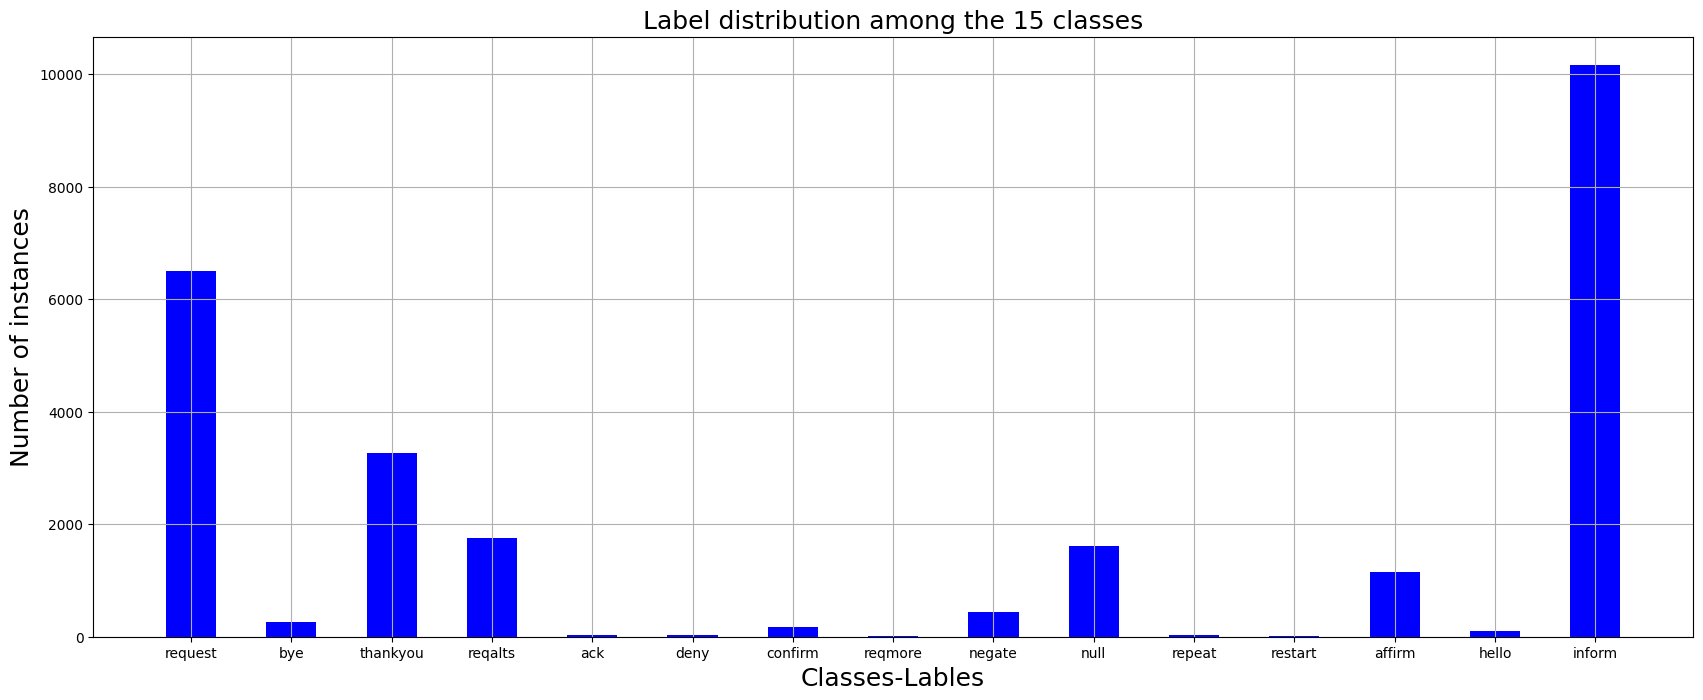

The maximum utterance length in the dataset is:  23
The minimum utterance length in the dataset is:  1
The average utterance length in the dataset is:  3.729


In [28]:
all_scores = []
all_scores.append(n_zero)
all_scores.append(n_keyword)
algo1.Statistics(data_as_frame)

##### Create, Train and Test the Machine Learning models

In [29]:
ml_model = Machine_learning_model(data_as_array,File1)
ml_model.pre_processing()
print()
mlnames = ['DT', 'LR', 'SVM', 'MLP']
ml_algos = [ml_model.decision_tree(),ml_model.logistic_regression(),ml_model.support_vector_machine(),ml_model.multi_layer_perceptron()]
for name_clf,clf in zip(mlnames,ml_algos):
    score_ml = ml_model.ml_model_train_test(clf,name_clf)
    all_scores.append(score_ml)
    print()

X_encoded shape:  (25500, 767)
y_encoded shape:  (25500,)
X_train shape: (21675, 767) | X_test shape: (3825, 767) | y_train shape: (21675,) | y_test shape: (3825,)

The DT model on train set had 97.527 accuracy with a standard deviation of 0.13
Accuracy on Test set for the DT model is: 97.882
The label on which the most errors are observed is:  null

The LR model on train set had 97.730 accuracy with a standard deviation of 0.20
Accuracy on Test set for the LR model is: 98.196
The label on which the most errors are observed is:  confirm

The SVM model on train set had 98.233 accuracy with a standard deviation of 0.18
Accuracy on Test set for the SVM model is: 98.275
The label on which the most errors are observed is:  null

The MLP model on train set had 98.164 accuracy with a standard deviation of 0.24
Accuracy on Test set for the MLP model is: 98.536
The label on which the most errors are observed is:  null



##### Models results

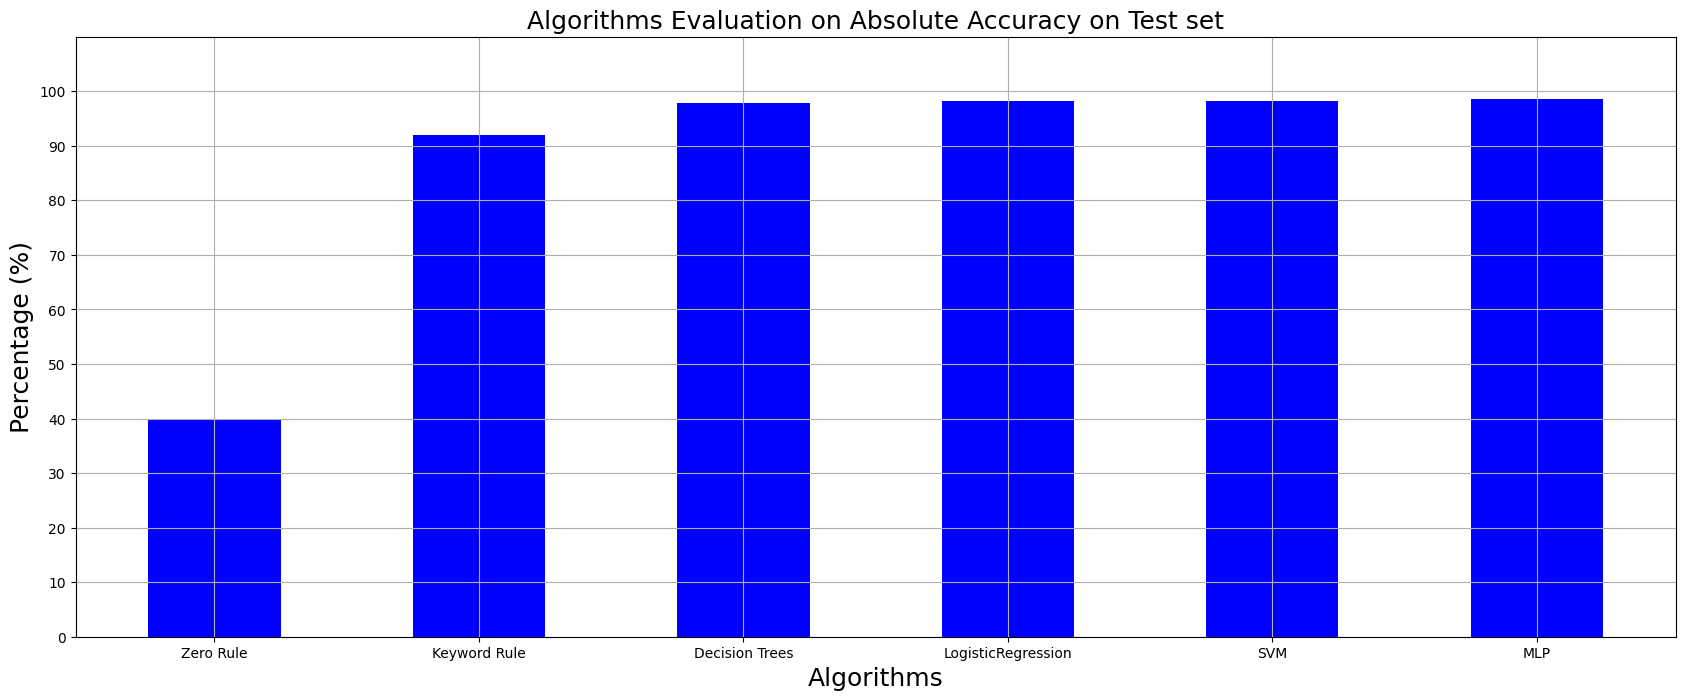

In [30]:
plot_results(all_scores)

##### Manual Input

In [31]:
utterances_new = ['God is love', 'I would like some cheap restaurnat', 'yes, I would like some food', 'nothing in the fridge']
clf_model = random.choice(ml_algos)
ml_model.manual_input(clf_model,utterances_new,inv_dict)

'God is love' => confirm
'I would like some cheap restaurnat' => null
'yes, I would like some food' => inform
'nothing in the fridge' => confirm


##### Pipeline System


In [32]:
index = ml_algos.index(clf_model)
resp_name = mlnames[index] 
ml_model.pipeline_system(clf_model,resp_name)

The accuracy of the DT pipeline system in test set is: 97.333


# Part 2 - Running

In [33]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
Classified as:  inform
Current State:  2
SYSTEM: What area?
Classified as:  inform
Current State:  3
SYSTEM: What price?
Classified as:  inform
Current State:  4
SYSTEM: What type of food?
Classified as:  inform
Current State:  5
Area: north |  price: any |  Type of food: any
SYSTEM: Do you have additional requirements?
Classified as:  negate
SYSTEM SUGGESTION:  Hakka is a Cheap priced restaurant in the North that serves Persian food. 
The remaining restaurants with these preferences are: 15
SYSTEM: Is that okay for you?
Classified as:  inform
Current State:  6
SYSTEM: You can ask for the phone number, address or post code of the restaurant


C:\Users\yugio\AppData\Local\Temp\ipykernel_31012\2619334855.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_rest.drop(idx, axis=0, inplace=True)


Classified as:  inform
SYSTEM: Okay! The phone is:  01223 568988 , the address is:  milton road chesterton and the postcode is:  c.b 4
Current (Final) State:  7

Total Runtime: 72.05 s
The total number of TURNS needed, were:  7

-------> xokqq.mp3
The above file cannot be deleted because it is already opened on another app.


In [75]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: fuck off
SYSTEM: Sorry, but I don't think that you are speaking properly. If you say something like this again, I will terminate the conversation
Classified as:  inform
Current State:  2
SYSTEM: What area?
USER: okay
Classified as:  ack
Current State:  2
SYSTEM: There are no restaurants in this area, please choose a different area
USER: food plize
Classified as:  inform
Current State:  2
SYSTEM: There are no restaurants in this area, please choose a different area
USER: south
Classified as:  inform
Current State:  3
SYSTEM: What price?
USER: anything is fine by mee
Classified as:  reqalts
Current State:  4
SYSTEM: What type of food?
USER: any
Classified as:  inform
Current State:  5
Area: south |  price: any |  Type of food: any
SYSTEM: Do you have additional requirements?
USER: yes i want reserved seats
Classified as:  af

In [145]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: hi
Classified as:  hello
Current State:  1
SYSTEM: Hi, please express your restaurant preferences regarding area, price and food type
USER: k
Classified as:  inform
SYSTEM: Sorry, I can't understand you. Can you repeat it please?
USER: i want food
Classified as:  inform
Current State:  2
SYSTEM: What area?
USER: south
Classified as:  inform
Current State:  3
SYSTEM: What price?
USER: not expensive
Classified as:  deny
Current State:  4
SYSTEM: What type of food?
USER: any
Classified as:  inform
Current State:  5
Area: south |  price: cheap |  Type of food: any
SYSTEM: Do you have additional requirements?
USER: touristic place
Classified as:  inform
SYSTEM SUGGESTION:  La margherita is a Cheap priced restaurant in the South that serves Italian food. And it is also touristic because it is a cheap restaurant with good quality

In [147]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want food in the centre
Classified as:  inform
Current State:  3
SYSTEM: What price?
USER: i wouldnt prefer cheap
Classified as:  inform
Current State:  4
SYSTEM: What type of food?
USER: anything
Classified as:  reqalts
Current State:  5
Area: centre |  price: moderate |  Type of food: any
SYSTEM: Do you have additional requirements?
USER: romantic rest
Classified as:  inform
SYSTEM SUGGESTION:  Anatolia is a Moderate priced restaurant in the Centre that serves Turkish food. And it is also romantic because it allows you to stay for a long time
The length of chosen restaurants is: 2
USER: perfect
Classified as:  inform
Current State:  6
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: give them all
Classified as:  inform
SYSTEM: Okay! The phone is:  01223 362372 , the address is:  30

In [76]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: I would like a cheap restaurant
Classified as:  inform
Current State:  2
SYSTEM: What area?
USER: everything
Classified as:  inform
Current State:  2
SYSTEM: There are no restaurants in this area, please choose a different area
USER: anywhere bitch
SYSTEM: Sorry, but I don't think that you are speaking properly. If you say something like this again, I will terminate the conversation
Classified as:  inform
Current State:  4
SYSTEM: What type of food?
USER: spanish
Classified as:  inform
Current State:  5
Area: any |  price: cheap |  Type of food: spanish
SYSTEM: Do you have additional requirements?
USER: no
Classified as:  negate
SYSTEM SUGGESTION:  Pizza express is a Cheap priced restaurant in the Centre that serves Spanish food. 
The remaining restaurants with these preferences are: 1
SYSTEM: Is that okay for you?
USER: a

In [ ]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: hello
Classified as:  hello
Current State:  1
SYSTEM: Hi, please express your restaurant preferences regarding area, price and food type
USER: sil
Classified as:  null
SYSTEM: Sorry, I can't understand you. Can you repeat it please?
USER: i want some food
Classified as:  inform
Current State:  2
SYSTEM: What area?
USER: not in the center
Classified as:  deny
Current State:  3
SYSTEM: What price?
USER: cheap
Classified as:  inform
Current State:  4
SYSTEM: What type of food?
USER: any
Classified as:  inform
Current State:  5
Area: west |  price: cheap |  Type of food: any
SYSTEM: Do you have additional requirements?
USER: yes
Classified as:  affirm
SYSTEM: What would you like to have?
USER: to be touristic
Classified as:  inform
SYSTEM SUGGESTION:  Kohinoor is a Cheap priced restaurant in the West that serves Indian food. A

In [168]:
chat_obj = Chatbot('none', 'none', 'none', 0, labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
chat_obj.Main()

Current State:  0
SYSTEM: Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want an indian place in the center
Classified as:  inform
Current State:  3
SYSTEM: What price?
USER: any
Classified as:  inform
Current State:  5
Area: centre |  price: any |  Type of food: indian
SYSTEM: Do you have additional requirements?
USER: no
Classified as:  negate
SYSTEM SUGGESTION:  The gandhi is a Cheap priced restaurant in the Centre that serves Indian food. 
The length of chosen restaurants is: 2
USER: anything else?
Classified as:  reqalts
Current State:  5
SYSTEM: Okay, let's try again.
The length of chosen restaurants is: 1
SYSTEM SUGGESTION:  Mahal of cambridge is a Cheap priced restaurant in the Centre that serves Indian food. 
USER: okay
Classified as:  ack
Current State:  6
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: give them all
Classified as:  inform
SYST

## Part 3 - Running Short Chatbot

In [ ]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: I want a cheap indian restaurant
Classified as:  inform
The remaining restaurants with these preferences are:  4
SYSTEM SUGGESTION:  Royal spice is a Cheap priced restaurant in the North that serves Indian food.
SYSTEM: Is that okay? Yes/No
USER: no
Classified as:  negate
The remaining restaurants with these preferences are:  3
SYSTEM SUGGESTION:  The gandhi is a Cheap priced restaurant in the Centre that serves Indian food.
SYSTEM: Is that okay? Yes/No
USER: yes
Classified as:  affirm
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: phone pliz
Classified as:  request
SYSTEM: Okay! The phone is:  01223 353942

Total Runtime: 30.24 s
The total number of TURNS needed, were:  4


In [ ]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys)
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: I want a cheap restaurant in the centre
Classified as:  inform
The remaining restaurants with these preferences are:  12
SYSTEM SUGGESTION:  The river bar steakhouse and grill is a Cheap priced restaurant in the Centre that serves Modern european food.
SYSTEM: Is that okay? Yes/No
USER: perfect
Classified as:  inform
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: their phone
Classified as:  request
SYSTEM: Okay! The phone is:  01223 307030

Total Runtime: 30.41 s
The total number of TURNS needed, were:  3


In [ ]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER:  i want an expensive tuscan restaurant
Classified as:  inform
none expensive tuscan
The remaining restaurants with these preferences are:  1
SYSTEM SUGGESTION:  City stop restaurant is a Expensive priced restaurant in the North that serves Tuscan food.
SYSTEM: Is that okay? Yes/No
USER: no
Classified as:  negate
SYSTEM: Sorry there are no other alternatives that match your criteria.
SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want an moderate tuscan restaurant
Classified as:  inform
none moderate tuscan
The remaining restaurants with these preferences are:  0
SYSTEM: Sorry there are no restaurants that match your criteria.
SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food

In [149]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want chinese food
Classified as:  inform
none none chinese
The remaining restaurants with these preferences are:  9
SYSTEM SUGGESTION:  Peking restaurant is a Expensive priced restaurant in the South that serves Chinese food.


C:\Users\admitos\Anaconda3\.cph_tmpbukjua9p\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


SYSTEM: Is that okay? Yes/No
USER: yes
Classified as:  affirm
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: give them all
Classified as:  inform
SYSTEM: Okay! The phone is:  01223 354755 , the address is:  10 homerton street city centre and postcode is:  c.b 2

Total Runtime: 33.61 s
The total number of TURNS needed, were:  3

-------> mtoyy.mp3
The above file cannot be deleted because it is already opened on another app.


In [ ]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys)
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want an italian and touristic restaurant
Classified as:  inform
none none italian
The remaining restaurants with these preferences are:  1
SYSTEM SUGGESTION:  La margherita is a Cheap priced and touristic restaurant in the South that serves Italian food.
SYSTEM: Is that okay? Yes/No
USER: no
Classified as:  negate
SYSTEM: Sorry there are no other alternatives that match your criteria.
SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: i want an expensive tuscan restaurant
Classified as:  inform
none expensive tuscan
The remaining restaurants with these preferences are:  1
SYSTEM SUGGESTION:  City stop restaurant is a Expensive priced restaurant in the North that serves Tuscan food.
SYSTEM: Is that okay? Yes/No
USER: no
Classified as:  negate
S

In [97]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
short_chat.main()

C:\Users\admitos\Anaconda3\.cph_tmpbukjua9p\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: hello
Classified as:  hello
none none none
SYSTEM: Okay, I assume that you dont have any preferences, so...
The remaining restaurants with these preferences are:  109
SYSTEM SUGGESTION:  Kymmoy is a Expensive priced restaurant in the Centre that serves Asian oriental food.
SYSTEM: Is that okay? Yes/No
USER: no
Classified as:  negate
The remaining restaurants with these preferences are:  108
SYSTEM SUGGESTION:  Saint johns chop house is a Moderate priced restaurant in the West that serves British food.
SYSTEM: Is that okay? Yes/No
USER: yes
Classified as:  affirm
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: give the all
Classified as:  inform
SYSTEM: Okay! The phone is:  01223 353110 , the address is:  21 - 24 northampton street and the postcode is:  c.b 3

Total Runtime: 55.89 s
The total number of 

In [29]:
short_chat = Shorten_Chatbot('none','none','none', labels_keys, "C:/Users/yugio/Projects/MAIR/Chatbot/")
short_chat.main()

SYSTEM: Hello, welcome to the Cambridge restaurant system? You can ask for restaurants by area, price range or food type. How may I help you?
USER: i need a European place to take my crash out. She lives west. Up to the task?
Classified as:  inform
west none european
The remaining restaurants with these preferences are:  1
SYSTEM SUGGESTION:  Cambridge lodge restaurant is a Expensive priced restaurant in the West that serves European food.
SYSTEM: Is that okay? Yes/No
USER: yes
Classified as:  affirm
SYSTEM: You can ask for the phone number, address or post code of the restaurant
USER: addresw plz
Classified as:  request
SYSTEM: Okay! The address is:  cambridge lodge hotel 139 huntingdon road city centre

Total Runtime: 143.37 s
The total number of TURNS needed, were:  3

-------> tqmaq.mp3
The above file cannot be deleted because it is already opened on another app.


In [90]:
restaurant_obj = Helper(0,time.time(),'restaurant_info_upgrade.csv')
restaurant_obj.type_food_list

['french',
 'polynesian',
 'romanian',
 'gastropub',
 'jamaican',
 'cuban',
 'traditional',
 'japanese',
 'steakhouse',
 'korean',
 'north american',
 'persian',
 'spanish',
 'indian',
 'vietnamese',
 'international',
 'fusion',
 'seafood',
 'tuscan',
 'asian oriental',
 'italian',
 'moroccan',
 'european',
 'portuguese',
 'australasian',
 'thai',
 'modern european',
 'chinese',
 'swiss',
 'catalan',
 'mediterranean',
 'british',
 'lebanese',
 'bistro',
 'turkish',
 'african']